# Импорты

In [1]:
import gc

import catboost as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from malware_src.prepare_data import (dtypes,
                                    TARGET_COLUMN, 
                                    categorical_cols, 
                                    numerical_cols, 
                                    dataframe_to_pool)
from malware_src.visualization import plot_roc_curve

Using TensorFlow backend.


# Загрузка и разделение данных

In [2]:
seed = 2019
val_part = 0.2
hold_part = 0.02

In [3]:
%%time
data_path = 'data/filtered_train_data.csv'
data = pd.read_csv(data_path, dtype=dtypes)

Wall time: 2min 19s


In [4]:
data.shape

(8921483, 68)

## Подготовка категориальных данных для моделей

In [5]:
# Выбираем OrdinalEncoder - как один из простейших и быстрых способов кодирования 
# категориальных данных. Например, OneHot кодирование мы не используем в целях 
# экономии ресурсов на вычисления и преобразования с работой полных данных. 
enc = OrdinalEncoder()

In [6]:
# Пропуски как в категориальных, так и в числовых данных далее мы заменяем
# на специальное значение: -1. Этот способ самый простой и удобный, не требует 
# дополнительных вычислений, в отличии от, например, замены на самый частотный элемент
# для категориальных и замены на медиану или среднее в числовых данных.
# Убрать все NaN в категориальных столбцах и заменить их на '-1'.
# Так как тип данных - категориальный, NaN заполняются строкой
category_data = data.loc[:, categorical_cols]
for col in categorical_cols:
    try:
        category_data.loc[:, col] = category_data[col].fillna('-1')
    except ValueError:
        category_data[col] = category_data[col].cat.add_categories('-1')
        category_data.loc[:, col] = category_data[col].fillna('-1')

In [7]:
category_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 59 columns):
EngineVersion                              8921483 non-null category
AppVersion                                 8921483 non-null category
AvSigVersion                               8921483 non-null category
RtpStateBitfield                           8921483 non-null category
DefaultBrowsersIdentifier                  8921483 non-null category
AVProductStatesIdentifier                  8921483 non-null category
AVProductsInstalled                        8921483 non-null category
AVProductsEnabled                          8921483 non-null category
CountryIdentifier                          8921483 non-null category
CityIdentifier                             8921483 non-null category
OrganizationIdentifier                     8921483 non-null category
GeoNameIdentifier                          8921483 non-null category
LocaleEnglishNameIdentifier                8921483 non-null

In [8]:
enc.fit(category_data)

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [9]:
# Получаем nparray, заполненный числами, каждое из которых соответсвует
# своей категории в конкретном столбце.
filtered_category_data = enc.transform(category_data)

In [10]:
numeric_data = data.loc[:, numerical_cols]

In [11]:
filtered_numeric_data = numeric_data.to_numpy()

In [12]:
# Убрать все NaN в числовых столбцах и заменить их на -1.
# Тип столбцов числовой, поэтому заменяется на -1, а не '-1'
for col in numerical_cols:
    try:
        numeric_data.loc[:, col] = numeric_data[col].fillna(-1)
    except ValueError:
        numeric_data[col] = numeric_data[col].cat.add_categories(-1)
        numeric_data.loc[:, col] = numeric_data[col].fillna(-1)

In [13]:
full_data = np.concatenate((filtered_numeric_data, filtered_category_data), axis=1)

In [14]:
full_data

array([[4.00000e+00, 4.76940e+05, 2.99451e+05, ..., 1.00000e+00,
        2.00000e+00, 0.00000e+00],
       [4.00000e+00, 4.76940e+05, 1.02385e+05, ..., 1.00000e+00,
        1.40000e+01, 0.00000e+00],
       [4.00000e+00, 1.14473e+05, 1.13907e+05, ..., 1.00000e+00,
        9.00000e+00, 0.00000e+00],
       ...,
       [8.00000e+00, 2.44198e+05, 2.42989e+05, ..., 1.00000e+00,
        1.30000e+01, 1.00000e+00],
       [2.00000e+00, 4.76940e+05, 4.63486e+05, ..., 1.00000e+00,
        5.00000e+00, 1.00000e+00],
       [4.00000e+00, 9.53869e+05, 6.37127e+05, ..., 1.00000e+00,
        3.00000e+00, 0.00000e+00]])

In [31]:
gc.collect()

7454

### Разделение данных на тестовую и проверочную выборки

In [16]:
train_data, val_data = train_test_split(full_data, test_size=val_part, random_state=seed)

In [17]:
train_data = np.nan_to_num(train_data)
val_data = np.nan_to_num(val_data)

In [18]:
np.argwhere(np.isnan(train_data))

array([], shape=(0, 2), dtype=int64)

In [19]:
np.argwhere(np.isnan(val_data))

array([], shape=(0, 2), dtype=int64)

## Обучение моделей

### GaussianNB

In [20]:
gauss_model = GaussianNB()

In [21]:
%%time
gauss_model.fit(train_data[:,0:-1], train_data[:,-1])

Wall time: 13.8 s


GaussianNB(priors=None, var_smoothing=1e-09)

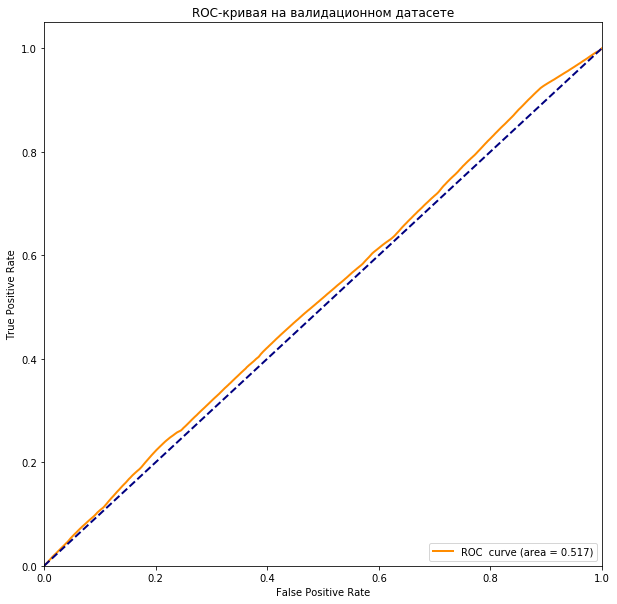

In [22]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[:,-1],
               pred=gauss_model.predict_proba(val_data[:,0:-1])[:,1],
               name='ROC-кривая на валидационном датасете',
               p_label=1)

### BernoulliNB

In [23]:
bernoulli_model = BernoulliNB()

In [24]:
%%time
bernoulli_model.fit(train_data[:,0:-1], train_data[:,-1])

Wall time: 9.5 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

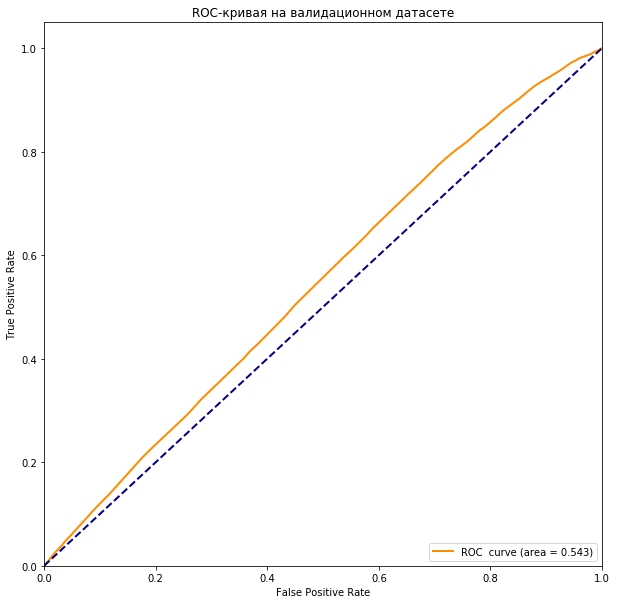

In [25]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[:,-1],
               pred=bernoulli_model.predict_proba(val_data[:,0:-1])[:,1],
               name='ROC-кривая на валидационном датасете',
               p_label=1)

### Keras sequential

In [20]:
# Преобразование числового столбца в бинарный для работы с линейной моделью
binary_target = to_categorical(train_data[:, -1])

In [27]:
%%time
seq_model = Sequential()

# Активационная функция softmax нужна для категориальных данных на выходе
seq_model.add(Dense(128, input_dim=len(train_data[0])-1, activation='sigmoid'))
seq_model.add(Dense(128, activation='sigmoid'))
seq_model.add(Dense(2, activation='softmax'))

# Так как таргет может быть либо 0 либо 1, то ошибку считаем по бинарной кроссэнтропии.
# Метрика точности так же задаётся для бинарного таргета 
seq_model.compile(loss='binary_crossentropy', 
                optimizer=Adam(), 
                metrics=['binary_accuracy'] 
                )

seq_model.fit(
            x=train_data[:, 0:-1],
            y=binary_target,
            epochs=50,
            batch_size=200000
            )

Epoch 1/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6921 - binary_accuracy: 0.5181
Epoch 2/50
7137186/7137186 [==============================] - 18s 2us/step - loss: 0.6904 - binary_accuracy: 0.5256
Epoch 3/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6901 - binary_accuracy: 0.5263
Epoch 4/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6902 - binary_accuracy: 0.5261
Epoch 5/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6902 - binary_accuracy: 0.5248
Epoch 6/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6900 - binary_accuracy: 0.5258
Epoch 7/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6903 - binary_accuracy: 0.5254
Epoch 8/50
7137186/7137186 [==============================] - 18s 3us/step - loss: 0.6902 - binary_accuracy: 0.5244
Epoch 9/50
7137186/7137186 [==============================] - 18s 3us/st

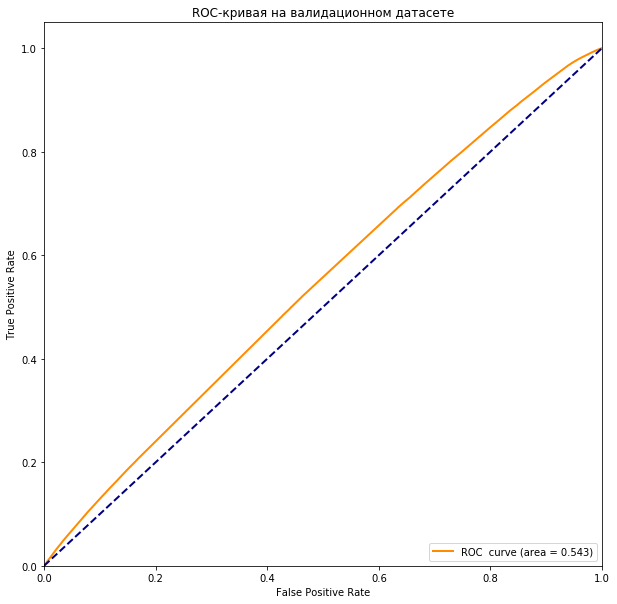

In [28]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[:, -1],
            pred=seq_model.predict_proba(val_data[:, 0:-1])[:,1],
            name='ROC-кривая на валидационном датасете',
            p_label=1)

### RandomForestClassifier

In [29]:
%%time
rf_model = RandomForestClassifier(n_estimators=50)
rf_model.fit(train_data[:, 0:-1], binary_target)

Wall time: 56min 22s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

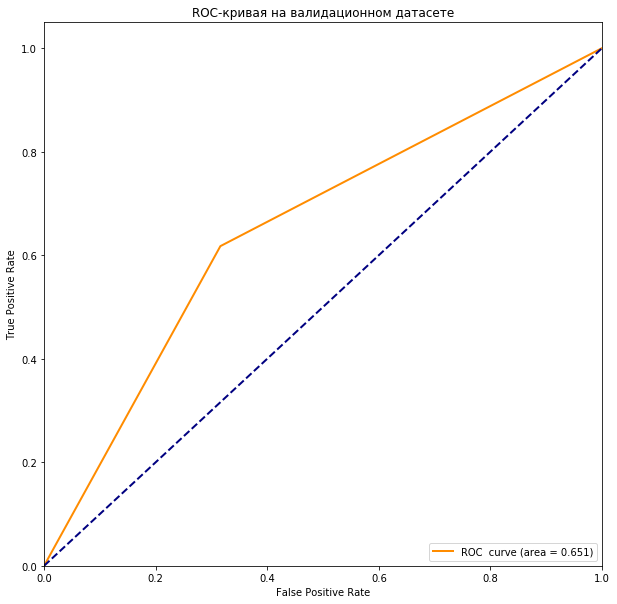

In [30]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[:, -1],
            pred=rf_model.predict(val_data[:, 0:-1])[:, 1],
            name='ROC-кривая на валидационном датасете',
            p_label=1)

### Выводы

Простые модели наивного байеса показали себя чуть лучше, чем подкидывание монетки. При этом Гауссовская модель заметно отстаёт от Бернулли. Отсюда делается вывод, что исходные данные имеют мало общего с распредлением по Бернулли и тем более по Гауссу. 
Классическая линейная модель показала аналогичный результат с наивным байесом по Бернулли. Скорее всего, данные слишком сложные для предложенной структуры нейросети. Также, по логу keras видно, что ошибка за 2 первые эпохи спускается до конкретного числа и больше не может существенно сдвинуться с этой точки, это следствие попадания в локальный минимум. А лучше всего с существенным отрывом от других моделей себя показал случайный лес.

# Подготовка данных для Catboost

###  Обучение

In [20]:
train_val_data, hold_data = train_test_split(data, test_size=hold_part, random_state=seed)
train_data, val_data = train_test_split(train_val_data, test_size=val_part, random_state=seed)

In [21]:
print(data.shape[0], train_data.shape[0], val_data.shape[0], hold_data.shape[0])

8921483 6994442 1748611 178430


In [22]:
categorical_cols.remove(TARGET_COLUMN)

In [23]:
train_pool = dataframe_to_pool(train_data, numerical_cols, categorical_cols, TARGET_COLUMN)
val_pool = dataframe_to_pool(val_data, numerical_cols, categorical_cols, TARGET_COLUMN)

In [24]:
hold_data.to_csv('data/hold_data.csv', index=False)

In [29]:
model = cb.CatBoostClassifier(iterations=100, learning_rate = 0.3)

In [30]:
%%time
model.fit(train_pool, eval_set=val_pool, plot=True, verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6659609	test: 0.6658177	best: 0.6658177 (0)	total: 14.7s	remaining: 24m 17s
1:	learn: 0.6502108	test: 0.6498260	best: 0.6498260 (1)	total: 27.4s	remaining: 22m 21s
2:	learn: 0.6423387	test: 0.6419243	best: 0.6419243 (2)	total: 40s	remaining: 21m 33s
3:	learn: 0.6371035	test: 0.6366149	best: 0.6366149 (3)	total: 49s	remaining: 19m 36s
4:	learn: 0.6338038	test: 0.6332174	best: 0.6332174 (4)	total: 58.1s	remaining: 18m 23s
5:	learn: 0.6318516	test: 0.6312395	best: 0.6312395 (5)	total: 1m 7s	remaining: 17m 29s
6:	learn: 0.6301854	test: 0.6295066	best: 0.6295066 (6)	total: 1m 16s	remaining: 16m 49s
7:	learn: 0.6285788	test: 0.6278327	best: 0.6278327 (7)	total: 1m 25s	remaining: 16m 18s
8:	learn: 0.6276245	test: 0.6267885	best: 0.6267885 (8)	total: 1m 33s	remaining: 15m 49s
9:	learn: 0.6267443	test: 0.6258466	best: 0.6258466 (9)	total: 1m 42s	remaining: 15m 26s
10:	learn: 0.6261198	test: 0.6251940	best: 0.6251940 (10)	total: 1m 51s	remaining: 15m 5s
11:	learn: 0.6256070	test: 0.6

In [31]:
model_path = 'models/model.cb'
model.save_model(model_path)

In [32]:
feature_importance = model.get_feature_importance()
features = model.feature_names_

for feature_id in feature_importance.argsort()[::-1]:
    name = features[feature_id]
    importance = feature_importance[feature_id]
    print(f'{name:50}\t\t{importance}')

SmartScreen                                       		34.7943601535956
AVProductStatesIdentifier                         		13.853567782873736
AVProductsInstalled                               		5.498047296969141
AppVersion                                        		4.494099458456841
EngineVersion                                     		4.146383112654197
Census_ProcessorModelIdentifier                   		4.0202985813037975
AvSigVersion                                      		3.421595089106621
CountryIdentifier                                 		2.773681225618472
Wdft_IsGamer                                      		2.703384333437612
Census_OSInstallTypeName                          		2.4692666823566047
Census_OEMModelIdentifier                         		1.474884528985771
Wdft_RegionIdentifier                             		1.4179157100027286
Census_ActivationChannel                          		1.2450214311940013
Census_TotalPhysicalRAM                           		1.1744333778298162
Census_OEMNameI

### Тест

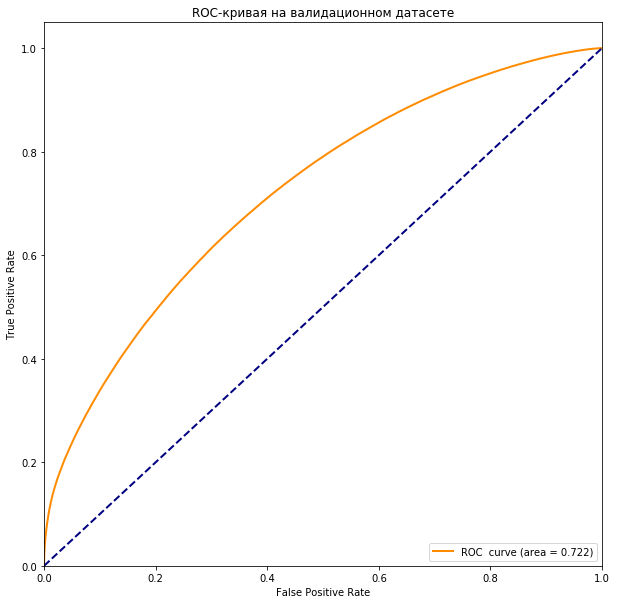

In [54]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_pool.get_label(),
               pred=model.predict_proba(val_pool)[:,1],
               name='ROC-кривая на валидационном датасете',
               p_label='1')